In [94]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.cross_validation import cross_val_score, train_test_split

from patsy import dmatrices, dmatrix

from datetime import date, datetime

import mkl
import accelerate

pd.set_option('display.max_columns', None)


# Suppress annoying deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data Import

In [95]:
train_data = pd.read_csv('train.csv', parse_dates=['DateTime'])
test_data = pd.read_csv('test.csv', parse_dates=['DateTime'])

n_train_data = len(train_data.index)

# 1 - Feature Engineering

In [96]:
# Utility functions
# From: http://stackoverflow.com/a/28688724
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)


In [97]:
# Merge for engineering (will split later)

feature_columns = ['AnimalID', 'Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 
                    'AgeuponOutcome', 'Breed', 'Color', 'OutcomeType']

train_features = train_data.loc[:, feature_columns]
test_features = test_data.loc[:, feature_columns]
data = pd.concat((train_features, test_features), ignore_index=True)

In [98]:
data['Season'] = data.DateTime.map(get_season)
data['Sex X Species'] = data.SexuponOutcome + ' ' + data.AnimalType

In [99]:
train_data = data[:n_train_data]
test_data = data[n_train_data:]

print len(train_data.index)
print len(test_data.index)

26729
11456


# 2 - Comapring train and test data distributions

In [100]:
train_data.describe()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType,Season,Sex X Species
count,26729,19038,26729,26729,26728,26711,26729,26729,26729,26729,26728
unique,26729,6374,22918,2,5,44,1380,366,5,4,10
top,A705677,Max,2015-08-11 00:00:00,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White,Adoption,autumn,Neutered Male Dog
freq,1,136,19,15595,9779,3969,8810,2824,10769,7777,6714
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-02-21 19:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# Function to plot bar charts of categorical variables, with 
# train and test bars side-by-side. Hard-coded to use data from global env
def barplot_testvtrain(field_name):
    train_size = len(train_data.index) * 1.0
    test_size = len(test_data.index) * 1.0

    train_dist = train_data.groupby(field_name).size() / train_size
    test_dist = test_data.groupby(field_name).size() / test_size
    
    indices = np.arange(train_dist.size)
    width = .35
    
    fig, ax = plt.subplots()
    plt.title('{} distribution'.format(field_name))
    
    train_rects = ax.bar(indices, train_dist, width, color='r')
    test_rects = ax.bar(indices + width, test_dist, width, color='b')

    ax.set_xticks(indices + width)
    ax.set_xticklabels(train_dist.index, rotation=45)

    ax.legend((train_rects[0], test_rects[0]), ('Train', 'Test'), loc=0)
    plt.show()

<class 'pandas.core.series.Series'>
Cat    0
Dog    0
dtype: int64


Category: Adoption
<class 'pandas.core.series.Series'>
dist:
AnimalType
Cat    0.383690
Dog    0.416608
dtype: float64
bottoms:
Cat    0.383690
Dog    0.416608
dtype: float64



Category: Transfer
<class 'pandas.core.series.Series'>
dist:
AnimalType
Cat    0.494431
Dog    0.251170
dtype: float64
bottoms:
Cat    0.878121
Dog    0.667778
dtype: float64



Category: Return_to_owner
<class 'pandas.core.series.Series'>
dist:
AnimalType
Cat    0.044907
Dog    0.274832
dtype: float64
bottoms:
Cat    0.923029
Dog    0.942610
dtype: float64



Category: Euthanasia
<class 'pandas.core.series.Series'>
dist:
AnimalType
Cat    0.063769
Dog    0.054184
dtype: float64
bottoms:
Cat    0.986797
Dog    0.996794
dtype: float64



Category: Died
<class 'pandas.core.series.Series'>
dist:
AnimalType
Cat    0.013203
Dog    0.003206
dtype: float64
bottoms:
Cat    1
Dog    1
dtype: float64



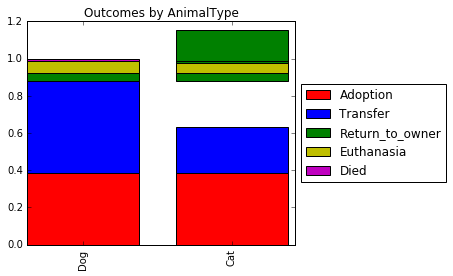

In [159]:
# Function to generate stacked bar charts of outcome v. categorical variable,
# hard-coded to use data from global env
def barplot_stacked(field_name):
    plot_data = pd.DataFrame()
    plot_data[field_name] = train_data[field_name]
    plot_data['OutcomeType'] = train_data.OutcomeType
    plot_data = plot_data.dropna()

    # List of outcomes in order to stack, togetehr with assigned color
    outcomes = [('Adoption', 'r'), 
                ('Transfer', 'b'), 
                ('Return_to_owner', 'g'), 
                ('Euthanasia', 'y'), 
                ('Died', 'm')]

    # Getting information about the categories in the variable
    categories = plot_data[field_name].unique()
    cat_counts = plot_data.groupby(field_name).size()
    indices = np.arange(categories.size)
    
    width = .75
    barsets = []
    bottoms = pd.Series({c:0 for c in categories})

    print type(bottoms)
    print bottoms
    
    fig, ax = plt.subplots()
    plt.title('Outcomes by {}'.format(field_name))

    # Loop over outcomes, generate bars, and stack them
    for outcome, c in outcomes:
        print ""
        print ""
        print 'Category: {}'.format(outcome)
        dist = plot_data.loc[plot_data.OutcomeType == outcome] \
                         .groupby(field_name) \
                         .size() \
                         / cat_counts
        print type(dist)
        print "dist:"
        print dist
                    
        bs = ax.bar(indices, dist, width, color=c, bottom = bottoms[0])
        
        # Keep track of what we've done. Move the points from which
        # to draw the bars up a notch.
        barsets.append(bs)
        bottoms = bottoms.add(dist, 'index', fill_value=0.0)
        print "bottoms:"
        print bottoms
        print ""

    # Drawing category labels
    ax.set_xticks(indices + (width / 2))
    ax.set_xticklabels(categories, rotation=90)

    # Drawing legend outside of plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend([bs[0] for bs in barsets], 
              [n[0] for n in outcomes], 
              loc='center left', 
              bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
barplot_stacked('AnimalType')



In [155]:
labels = ['red', 'green', 'blue']

s1 = pd.Series({l: 1 for l in labels})
s2 = pd.Series({'red': 1, 'green':2})

print s1
print ""
print s2

s1.add(s2, fill_value=0)


blue     1
green    1
red      1
dtype: int64

green    2
red      1
dtype: int64


blue     1
green    3
red      2
dtype: float64

In [ ]:
barplot_testvtrain('AnimalType')
barplot_testvtrain('SexuponOutcome')
barplot_testvtrain('Season')

[]
AnimalType
Cat    0.383690
Dog    0.416608
dtype: float64


NotImplementedError: fill_value 0 not supported.

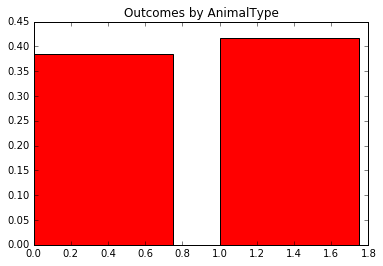

In [137]:
barplot_stacked('AnimalType')
barplot_stacked('SexuponOutcome')
barplot_stacked('Sex X Species')
barplot_stacked('Season')